In [ ]:
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.ma.core import size
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.7.0


CPU değerlerinin bulunduğu veriseti

In [164]:
df = pd.read_csv('cpu_utilizations.csv',sep=';')
df.head()

,datetime,cpu_usage
0,Sat Sep 10 2022 20:00:00 GMT+0300 (GMT+03:00),0.045620
1,Sat Sep 10 2022 21:00:00 GMT+0300 (GMT+03:00),0.046803
2,Sat Sep 10 2022 22:00:00 GMT+0300 (GMT+03:00),0.047473
3,Sat Sep 10 2022 23:00:00 GMT+0300 (GMT+03:00),0.044281
4,Sun Sep 11 2022 00:00:00 GMT+0300 (GMT+03:00),0.056652


In [165]:
df['cpu_usage'] = df.cpu_usage * 10
df.head()

,datetime,cpu_usage
0,Sat Sep 10 2022 20:00:00 GMT+0300 (GMT+03:00),0.456195
1,Sat Sep 10 2022 21:00:00 GMT+0300 (GMT+03:00),0.468027
2,Sat Sep 10 2022 22:00:00 GMT+0300 (GMT+03:00),0.474732
3,Sat Sep 10 2022 23:00:00 GMT+0300 (GMT+03:00),0.442814
4,Sun Sep 11 2022 00:00:00 GMT+0300 (GMT+03:00),0.566520


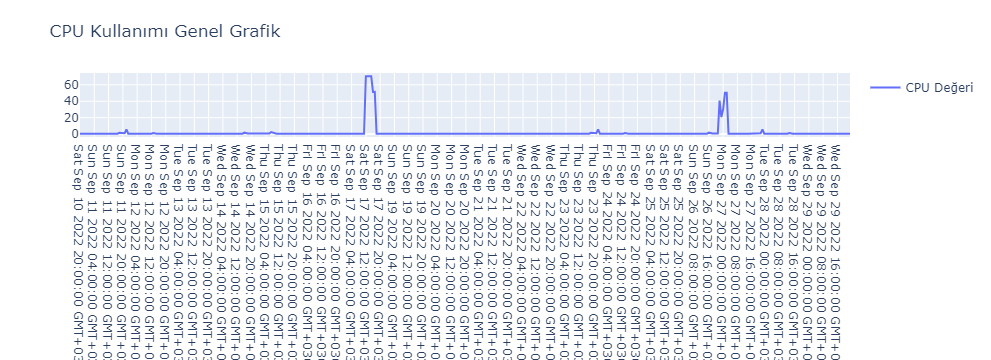

In [166]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['datetime'], y=df['cpu_usage'], name='CPU Değeri'))
fig.update_layout(showlegend=True, title='CPU Kullanımı Genel Grafik')
fig.show()

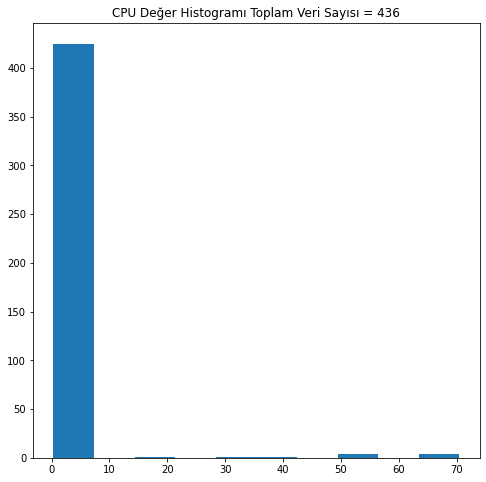

In [167]:
plt.figure(figsize=(8,8))
plt.hist(df['cpu_usage'])
plt.title(f"CPU Değer Histogramı Toplam Veri Sayısı = {len(df['cpu_usage'])}")
plt.show()

In [168]:
train, test= train_test_split(df, test_size=0.20, shuffle=False)
print(f" Eğitim veri sayısı = {len(train)}", "\n", f"Test veri sayısı {len(test)}")

 Eğitim veri sayısı = 348 
 Test veri sayısı 88


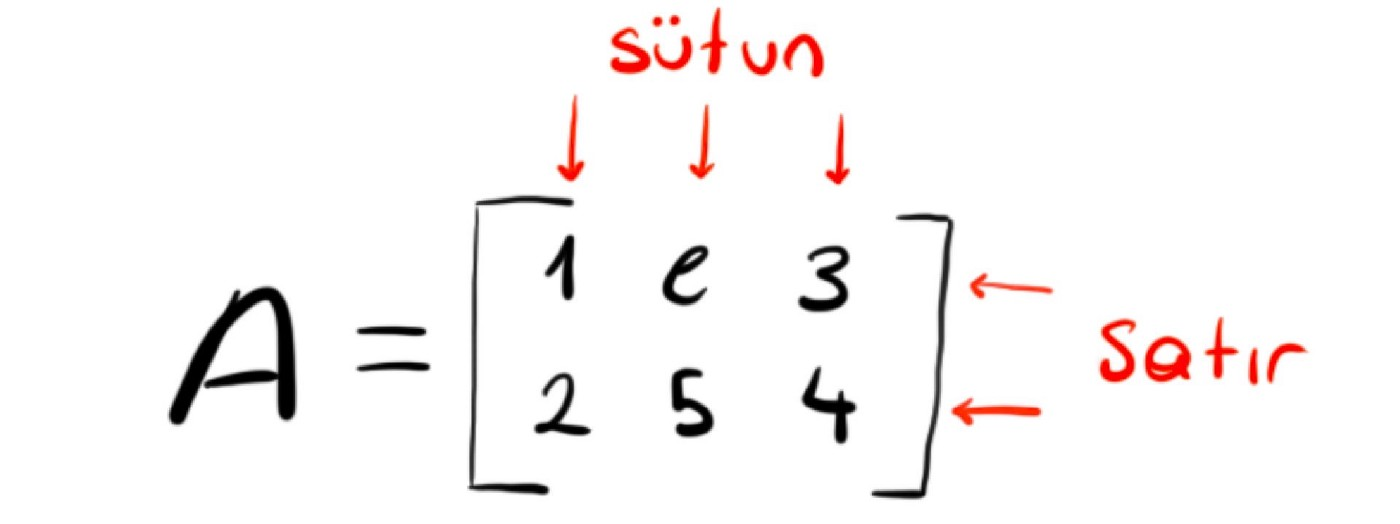!

In [169]:
train.shape, test.shape

((348, 2), (88, 2))

In [38]:
test

,datetime,cpu_usage
348,Sun Sep 26 2022 08:00:00 GMT+0300 (GMT+03:00),0.053625
349,Sun Sep 26 2022 09:00:00 GMT+0300 (GMT+03:00),0.046375
350,Sun Sep 26 2022 10:00:00 GMT+0300 (GMT+03:00),0.049485
351,Sun Sep 26 2022 11:00:00 GMT+0300 (GMT+03:00),0.060962
352,Sun Sep 26 2022 12:00:00 GMT+0300 (GMT+03:00),0.049546
...,...,...
431,Wed Sep 29 2022 19:00:00 GMT+0300 (GMT+03:00),0.057476
432,Wed Sep 29 2022 20:00:00 GMT+0300 (GMT+03:00),0.050241
433,Wed Sep 29 2022 21:00:00 GMT+0300 (GMT+03:00),0.048366
434,Wed Sep 29 2022 22:00:00 GMT+0300 (GMT+03:00),0.049914


In [ ]:
#scaler = StandardScaler()
#scaler = scaler.fit(train[['cpu_usage']])

#train['cpu_usage'] = scaler.transform(train[['cpu_usage']])
#test['cpu_usage'] = scaler.transform(test[['cpu_usage']])

LSTM girişi 3 boyutlu bir tensor beklemektedir.

[batch_size, timesteps, feature]

batch_size= Her dizide kaç tane örnek olacağı

timesteps= Bir dizi içinde kaç eleman olduğu, zamana bağlı ise ilişkilendirme ona göre belirlenir.

feature= Dizinin nasıl çözüleceği decimal gibi...

X=[4, 7, 8, 4]

10 boyutlu (özellik = 10) one hot encoded biçimde:

X=[[0 0 0 0 1 0 0 0 0 0]

[0 0 0 0 0 0 0 1 0 0]

[0 0 0 0 0 0 0 0 1 0]

[0 0 0 0 1 0 0 0 0 0]]

In [197]:
TIME_STEPS= 12

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['cpu_usage']], train['cpu_usage'])
X_test, y_test = create_sequences(test[['cpu_usage']], test['cpu_usage'])

print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (336, 12, 1)
Testing shape: (76, 12, 1)


In [44]:
X_train

array([[[0.45619547],
        [0.46802666],
        [0.47473197],
        ...,
        [0.53137648],
        [0.57939486],
        [0.48359829]],

       [[0.46802666],
        [0.47473197],
        [0.44281355],
        ...,
        [0.57939486],
        [0.48359829],
        [0.49020969]],

       [[0.47473197],
        [0.44281355],
        [0.56651985],
        ...,
        [0.48359829],
        [0.49020969],
        [0.4478052 ]],

       ...,

       [[0.54821365],
        [0.49266207],
        [0.57476175],
        ...,
        [0.49589674],
        [0.5073377 ],
        [0.50151989]],

       [[0.49266207],
        [0.57476175],
        [0.50241148],
        ...,
        [0.5073377 ],
        [0.50151989],
        [0.48969441]],

       [[0.57476175],
        [0.50241148],
        [0.4836576 ],
        ...,
        [0.50151989],
        [0.48969441],
        [0.64140227]]])

In [198]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_24 (RepeatVec  (None, 12, 128)          0         
 tor)                                                            
                                                                 
 lstm_50 (LSTM)              (None, 12, 128)           131584    
                                                                 
 dropout_49 (Dropout)        (None, 12, 128)           0         
                                                                 
 time_distributed_24 (TimeDi  (None, 12, 1)            129       
 stributed)                                          

In [199]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
11/11 [==============================] - 3s 40ms/step - loss: 1.4706
Epoch 2/10
11/11 [==============================] - 0s 41ms/step - loss: 1.3424
Epoch 3/10
11/11 [==============================] - 0s 40ms/step - loss: 1.3084
Epoch 4/10
11/11 [==============================] - 0s 41ms/step - loss: 1.2924
Epoch 5/10
11/11 [==============================] - 0s 41ms/step - loss: 1.2843
Epoch 6/10
11/11 [==============================] - 0s 41ms/step - loss: 1.2767
Epoch 7/10
11/11 [==============================] - 0s 40ms/step - loss: 1.2742
Epoch 8/10
11/11 [==============================] - 0s 40ms/step - loss: 1.2702
Epoch 9/10
11/11 [==============================] - 0s 40ms/step - loss: 1.2685
Epoch 10/10
11/11 [==============================] - 0s 45ms/step - loss: 1.2670


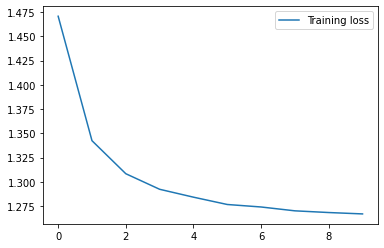

In [200]:
plt.plot(history.history['loss'], label='Training loss')
plt.legend();

Reconstruction error threshold: 31.835149137642773


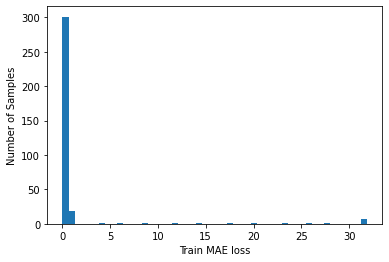

In [201]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

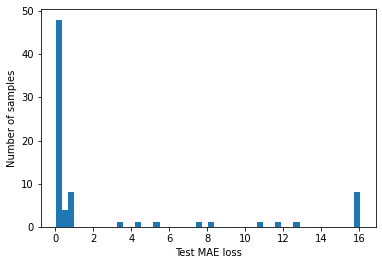

In [202]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [203]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['cpu_usage'] > test_score_df['threshold']
test_score_df['cpu_usage'] = test[TIME_STEPS:]['cpu_usage']

In [204]:
test_score_df

,datetime,cpu_usage,loss,threshold,anomaly
360,Sun Sep 26 2022 20:00:00 GMT+0300 (GMT+03:00),0.632332,0.192797,31.835149,False
361,Sun Sep 26 2022 21:00:00 GMT+0300 (GMT+03:00),0.690218,0.194820,31.835149,False
362,Sun Sep 26 2022 22:00:00 GMT+0300 (GMT+03:00),40.673414,0.208035,31.835149,True
363,Sun Sep 26 2022 23:00:00 GMT+0300 (GMT+03:00),20.703400,3.548589,31.835149,False
364,Mon Sep 27 2022 00:00:00 GMT+0300 (GMT+03:00),30.566520,5.223792,31.835149,False
...,...,...,...,...,...
431,Wed Sep 29 2022 19:00:00 GMT+0300 (GMT+03:00),0.574762,0.041594,31.835149,False
432,Wed Sep 29 2022 20:00:00 GMT+0300 (GMT+03:00),0.502411,0.050769,31.835149,False
433,Wed Sep 29 2022 21:00:00 GMT+0300 (GMT+03:00),0.483658,0.049856,31.835149,False
434,Wed Sep 29 2022 22:00:00 GMT+0300 (GMT+03:00),0.499140,0.040442,31.835149,False


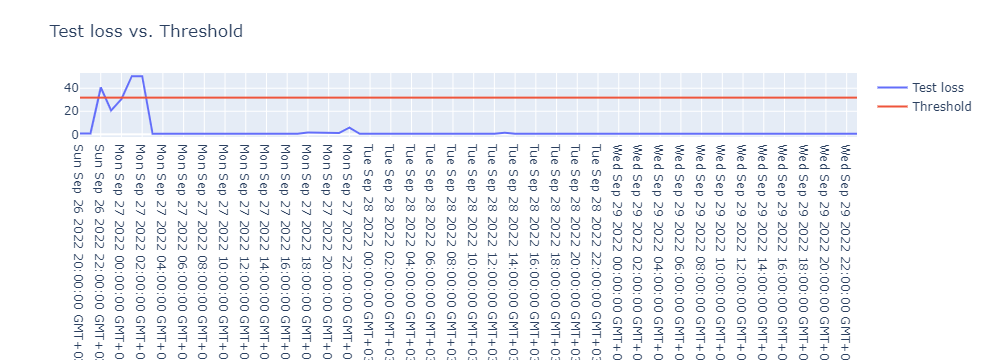

In [205]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['cpu_usage'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [206]:
anomalies = test_score_df[test_score_df['anomaly'] == True]
anomalies.head()

,datetime,cpu_usage,loss,threshold,anomaly
362,Sun Sep 26 2022 22:00:00 GMT+0300 (GMT+03:00),40.673414,0.208035,31.835149,True
365,Mon Sep 27 2022 01:00:00 GMT+0300 (GMT+03:00),50.439757,7.710635,31.835149,True
366,Mon Sep 27 2022 02:00:00 GMT+0300 (GMT+03:00),50.435992,11.847005,31.835149,True


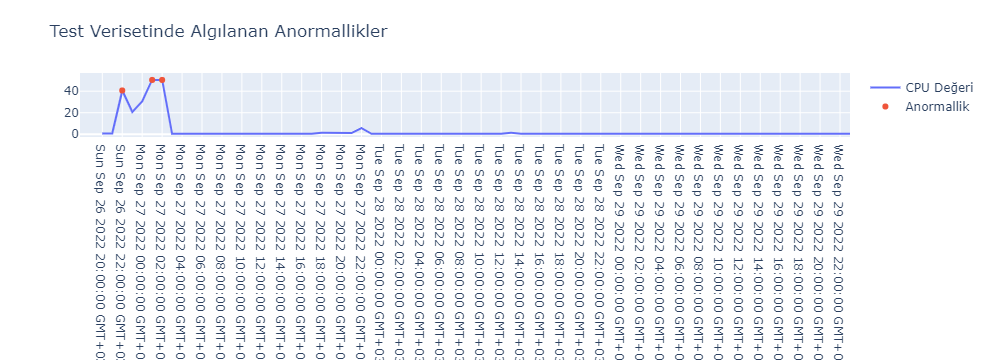

In [249]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=test_score_df['datetime'], y=(test_score_df['cpu_usage']), name='CPU Değeri'))
fig.add_trace(go.Scatter(x=anomalies['datetime'], y=(anomalies['cpu_usage']), mode='markers', name='Anormallik'))
fig.update_layout(showlegend=True, title=' Test Verisetinde Algılanan Anormallikler')
fig.show()

In [250]:
global_score_df = pd.DataFrame(train[TIME_STEPS:])
global_score_df['loss'] = train_mae_loss
global_score_df['threshold'] = threshold
global_score_df['anomaly'] = global_score_df['cpu_usage'] > global_score_df['threshold']
global_score_df['cpu_usage'] = train[TIME_STEPS:]['cpu_usage']

anomalies1 = global_score_df[global_score_df['anomaly'] == True]
anomalies1.head()

,datetime,cpu_usage,loss,threshold,anomaly
160,Sat Sep 17 2022 12:00:00 GMT+0300 (GMT+03:00),70.466997,0.030669,31.835149,True
161,Sat Sep 17 2022 13:00:00 GMT+0300 (GMT+03:00),70.402917,5.888185,31.835149,True
162,Sat Sep 17 2022 14:00:00 GMT+0300 (GMT+03:00),70.404428,11.710040,31.835149,True
163,Sat Sep 17 2022 15:00:00 GMT+0300 (GMT+03:00),70.405403,17.527876,31.835149,True
164,Sat Sep 17 2022 16:00:00 GMT+0300 (GMT+03:00),51.333683,23.341846,31.835149,True


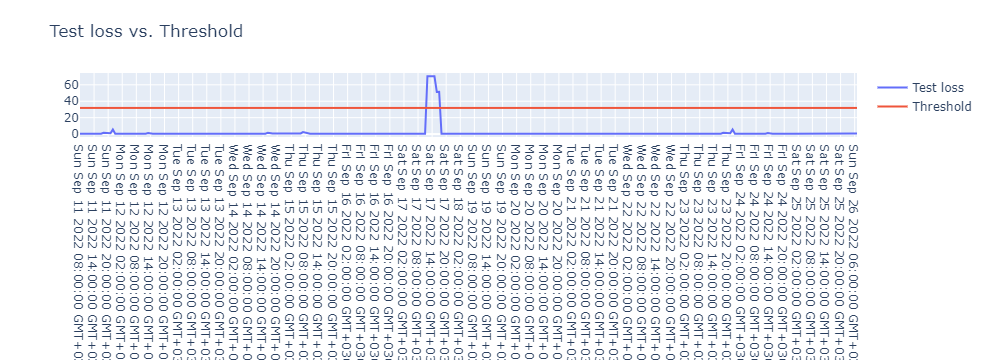

In [251]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=global_score_df['datetime'], y=global_score_df['cpu_usage'], name='Test loss'))
fig.add_trace(go.Scatter(x=global_score_df['datetime'], y=global_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

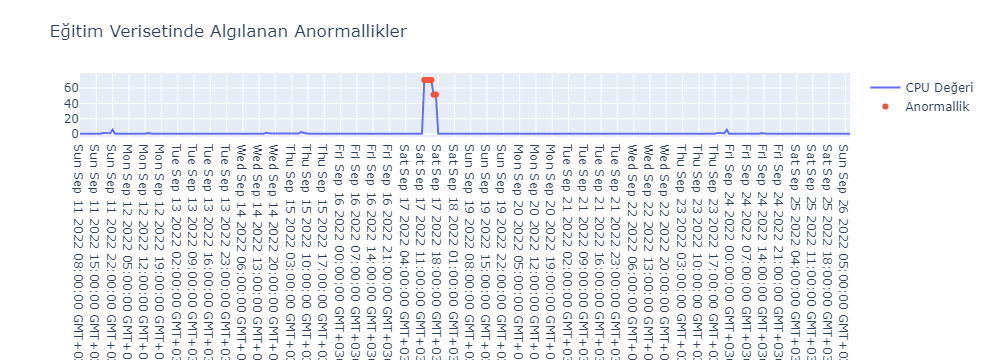

In [253]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=global_score_df['datetime'], y=(global_score_df['cpu_usage']), name='CPU Değeri'))
fig.add_trace(go.Scatter(x=anomalies1['datetime'], y=(anomalies1['cpu_usage']), mode='markers', name='Anormallik'))
fig.update_layout(showlegend=True, title='Eğitim Verisetinde Algılanan Anormallikler')